# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1hzamFV4kC27mUMEV9YGWnQmv2-k5TZvo/Challenge1


In [ ]:
# librerie prova, quelle da codalab
import tensorflow as tf
import scipy
import Cython
import numpy as np
import matplotlib
import seaborn as sns
import scipy
#import scikit_learn
#import scikit_image
import pandas as pd
#import pyyaml
import imutils
#import opencv-python
import tqdm
import psutil
import h5py

In [ ]:
# Fix randomness and hide warnings
seed = 42
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance, ImageFilter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)


from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
import scipy as sp
from tqdm import tqdm

2.14.0


# Load  dataset and process

In [ ]:
from tensorflow import keras as tfk
from sklearn.metrics import accuracy_score
seed=42
from sklearn.model_selection import train_test_split

In [ ]:
DATA = np.load('BalancedData.npz', allow_pickle=True)
X=DATA['data']
y_data=DATA['labels']
Y=(y_data=='unhealthy').astype(float)
Y = tfk.utils.to_categorical(Y)

# facendo labels[Y] si ottiene il valore in stringa
labels = {0:'healthy', 1:'unhealthy'}
del DATA

In [ ]:
from sklearn.model_selection import  KFold

#create the splits for the training

SPLITS = 3
kfold = KFold(n_splits=SPLITS, shuffle=True, random_state=seed)

TestX = []
TestY = []

TrainX = []
TrainY = []
ValX = []
ValY = []

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, Y)):
  print(test_idx[:20])
  TestX.append(X[test_idx])
  TestY.append(Y[test_idx])
  TVX = X[train_idx]
  TVY = Y[train_idx]

  TrX, VX, TrY, VY = train_test_split(
      TVX,
      TVY,
      test_size = 0.25,
      random_state = seed,
      stratify = TVY
      )
  TrainX.append(TrX)
  TrainY.append(TrY)
  ValX.append(VX)
  ValY.append(VY)
  ValX.append(X[test_idx])
  ValY.append(Y[test_idx])

TrainX = np.array(TrainX)
TrainY = np.array(TrainY)
ValX = np.array(ValX)
ValY = np.array(ValY)
TestX = np.array(TestX)
TestY = np.array(TestY)
del X,Y,TrX,TrY,VX,VY, TVX, TVY

[ 0  7 12 14 17 22 25 26 29 30 31 32 33 43 44 45 48 51 52 56]
[ 2  6  8 13 15 18 20 23 28 37 39 41 49 53 54 57 65 71 72 78]
[ 1  3  4  5  9 10 11 16 19 21 24 27 34 35 36 38 40 42 46 47]


# FirstTry





In [ ]:
# name to save models
name = 'Penalize'

In [ ]:
base_model=tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling='avg',
    include_preprocessing=True,
)
base_model.trainable = False

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance, ImageFilter

batch_size=64

# Create an instance of ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    fill_mode='nearest',
    brightness_range=[1.0, 1.3]  # Adjust brightness levels
)

In [ ]:
def build_model():
  dropout_rate=1/6
  he_initializer = tf.keras.initializers.HeNormal()
  inputs = tfk.Input(shape=(96, 96, 3))
  x = base_model(inputs)
  x=tfkl.Dense(128, activation = 'relu', kernel_initializer=he_initializer, name='Dense0')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)
  x=tfkl.Dense(64, activation = 'relu', kernel_initializer=he_initializer, name='Dense1')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)

  outputs = tfkl.Dense(2, activation='softmax', name='Outputs')(x)


  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='tl_model')
  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

  return tl_model

In [ ]:
#train the models

for n in range(SPLITS):
  print("Starting split:", n)
  print("Training Data Shape:", TrainX[n].shape)
  print("Training Label Shape:", TrainY[n].shape)
  print("Validation Data Shape:", ValX[n].shape)
  print("Validation Label Shape:", ValY[n].shape)

  augmented_generator = datagen.flow(TrainX[n], TrainY[n], batch_size=batch_size, seed=42)

  tl_model = build_model()
  # Train the model
  history = tl_model.fit(
      augmented_generator,
      validation_data=(ValX[n], ValY[n]),
      batch_size = batch_size,
      epochs = 350,
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)]
      ).history

  # Compute classification metrics
  train_pred=np.argmax(tl_model.predict(TrainX[n], verbose=0), axis=-1)
  train_accuracy = accuracy_score(TrainY[n][:,1], train_pred)
  val_pred=np.argmax(tl_model.predict(ValX[n], verbose=0), axis=-1)
  val_accuracy = accuracy_score(ValY[n][:,1], val_pred)

  # Display the computed metrics
  print('Training Accuracy:', train_accuracy.round(4))
  print('Validation Accuracy:', val_accuracy.round(4))

  tl_model.save(f'{name} Split{n}')

# Load models

In [ ]:
modelli=[]
for n in range(SPLITS):
  modelli.append(tfk.models.load_model(f'{name}Split{n}'))
models=np.array(modelli)

# Define Aug

In [ ]:
def h_flip(images):
    return np.flip(images, axis=2)
def v_flip(images):
    return np.flip(images, axis=1)

def v_flip2(image):
  return tf.keras.Sequential([tfkl.RandomFlip('vertical')])(image)

def trasl(image, a,b):    # valori [-1,1]   # aggiungi fill_mode={"constant", "reflect", "wrap", "nearest"}
  return tf.keras.Sequential([tfkl.RandomTranslation((a,a),(b,b), fill_mode='wrap')])(image)

def rotate(image, value):    # valori [-1,1]   # aggiungi fill_mode={"constant", "reflect", "wrap", "nearest"}
  return tf.keras.Sequential([tfkl.RandomRotation((value, value),fill_mode='reflect')])(image)

def zoom(image, value):      # valori [-1,1]   # aggiungi fill_mode={"constant", "reflect", "wrap", "nearest"}
  return tf.keras.Sequential([tfkl.RandomZoom((value,value))])(image)

def bright(image, a):      # a in [-1,1] da RandomRange(-a,a)    #si può provare fissato, ma metterei sia chiaro che scuro
  return tf.keras.Sequential([tfkl.RandomBrightness(a, value_range=(0,255))])(image)

def contrast(image, alpha):    # non puoi togliere il random, l'intervallo del fattore random sarà    (1-lower, 1+upper) che sono uguali se passi solo 1 valore
  return tf.keras.Sequential([tfkl.RandomContrast(alpha)])(image)

def grayscale(rgb_array):
    # Calculate the mean along the last axis (axis=3) to get the grayscale values
    values = np.mean(rgb_array, axis=3, keepdims=True).astype(int)

    # Stack the grayscale values along the fourth axis to create a grayscale image
    grayscale_images_array = np.concatenate([values, values, values], axis=3)

    return grayscale_images_array

In [ ]:
# Parametri per augmentation
Flip = np.array(["h", "v", "h+v"])
Trasl = np.array([-0.4, -0.3, -0.15, 0.15, 0.3, 0.4])
Rot = np.array([ -0.2, -0.1, -0.04, 0.04, 0.1, 0.2])
Zoom = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
Bright = np.array([0.1, 0.25, (-0.15, -0.15), (0.15, 0.15)])
Contr = np.array([0.1, 0.2, 0.4, 0.7, (0.5,0), (0,0.5)])     #gli ultimi due fanno solo contrast in su e in giù

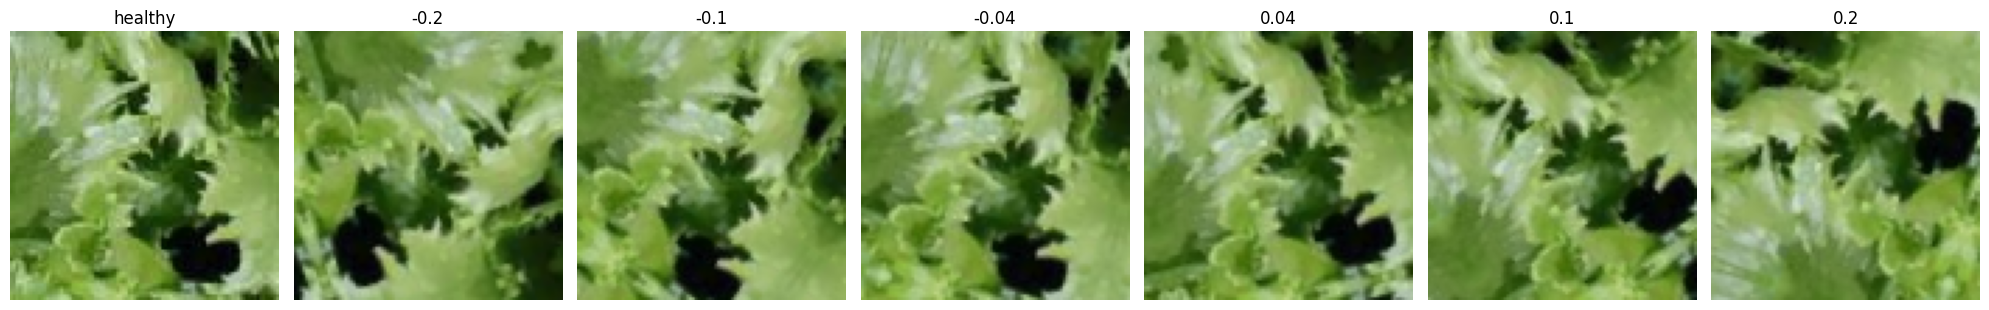

In [ ]:
k=23
Param = Rot       #cambiare qui
num_img = Param.size
fig, axes = plt.subplots(1, num_img+1, figsize=(20, 20))

ax=axes[0]
ax.imshow(TestX[0][k]/255)
ax.set_title( labels[TestY[0][k][1]] )
ax.axis('off')
for j in range(num_img):
    ax = axes[j+1]
    ax.imshow( rotate(TestX[0][k], Param[j] )/255)     # e qui (il resto non serve cambiarlo)
    ax.set_title( f'{Param[j]}' )
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
Alpha = [0.2, 0.4, 0.6, 0.8]
pred = np.empty((SPLITS,)+ TestY[0].shape)
accuracy = []
for qq in range(SPLITS):
  pred[qq] = models[qq].predict(TestX[qq])
  accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(pred[qq], axis=-1)))
acc = np.mean(accuracy)
Save = np.array(['base', acc])

38/38 [==============================] - 5s 41ms/step


# Aug Flip, Rot 90° and modify base model

In [ ]:
#pred Flip
Param = Flip
S=Param.size
predF = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  predF[qq][0] =models[qq].predict(h_flip(TestX[qq]))
  predF[qq][1] =models[qq].predict(v_flip(TestX[qq]))
  predF[qq][2] =models[qq].predict(v_flip(h_flip(TestX[qq])))

38/38 [==============================] - 2s 39ms/step


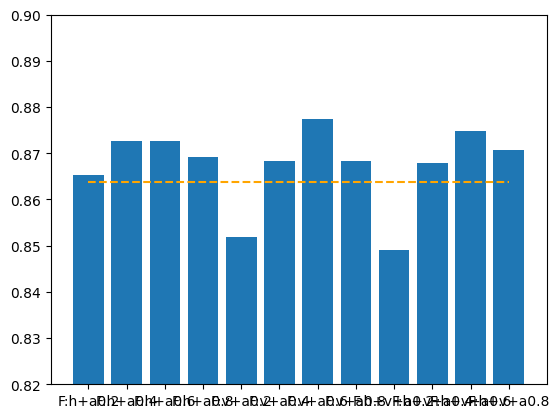


 ['F:h+a0.2' 'F:h+a0.4' 'F:h+a0.6' 'F:h+a0.8' 'F:v+a0.2' 'F:v+a0.4'
 'F:v+a0.6' 'F:v+a0.8' 'F:h+v+a0.2' 'F:h+v+a0.4' 'F:h+v+a0.6' 'F:h+v+a0.8'] 

No aug: 0.8637489677952105
Best aug: F:v+a0.6 -> 0.877511698320947

 (11, 2)


In [ ]:
#Flip
Pred = predF
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*pred[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'F:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [acc,acc] ,'--', color='orange')
plt.ylim(0.82, 0.90)
plt.show()
print('\n',Label, '\n')
print('No aug:', acc)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>acc):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

In [ ]:
#Dato che il Flip migliora sempre direi di unire le previsioni del base con i flip che mettiamo sicuro
#Forse su un modello che ha i flip nel preprocessing non vale la stessa cosa, runnare solo se è così
accuracy=[]
predf = np.empty(pred.shape)
for qq in range(SPLITS):
  print(accuracy_score(TestY[qq][:,1], np.argmax(pred[qq], axis=-1)))
  predf[qq]= (pred[qq]+predF[qq][0]+predF[qq][1])/3
  accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(predf[qq], axis=-1)))
  print(accuracy[-1])
print('vecchio acc = ', acc)
accf=np.mean(accuracy)
print('nuovo acc= ', accf)
Save = np.vstack([['BaseFlip', accf], Save])

vecchio acc =  0.8637489677952105
nuovo acc=  0.8786127167630058


In [ ]:
#    !!!!!!!!
# se vedi il nuovo acc < vecchio acc  allora runna la seguente riga
#   pred0=pred

In [ ]:
#Dato che il Rot 0.25 e 0.75 migliora sempre
#Forse su un modello che ha i Rot nel preprocessing non vale la stessa cosa, runnare solo se è così
#pred Flip
predR1 = np.empty((SPLITS,) + TestY[0].shape)
predR2 = np.empty((SPLITS,) + TestY[0].shape)

for qq in range(SPLITS):
  predR1[qq] =models[qq].predict(rotate(TestX[qq], 0.25))
  predR2[qq] =models[qq].predict(rotate(TestX[qq], 0.75))


accuracy=[]
predr = np.empty(predf.shape)
for qq in range(SPLITS):
  predr[qq]= (3*predf[qq]+predR1[qq]+predR2[qq])/5
  print(accuracy_score(TestY[qq][:,1], np.argmax(pred[qq], axis=-1)))
  accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(predr[qq], axis=-1)))
  print(accuracy[-1])
print('vecchio acc = ', accf)
accr=np.mean(accuracy)
print('nuovo acc= ', accr)
Save = np.vstack([['BaseFlipRot', accr], Save])

38/38 [==============================] - 1s 32ms/step
vecchio acc =  0.8786127167630058
nuovo acc=  0.8865951004679329


In [ ]:
#    !!!!!!!!
# se vedi il nuovo acc < vecchio acc  allora runna la seguente riga
#   predr=predf

In [ ]:
# Dato che abbiamo già aggiunto 2 test augmentation, adesso abbassiamo gli (1-alpha), non avrebbe senso andare troppo oltre gli 0.25
Alpha = [0.7, 0.85, 0.95]

# Trasl

In [ ]:
#pred #Trasl0
Param = Trasl
S=Param.size
predT0 = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predT0[qq][j] =  models[qq].predict(trasl(TestX[qq], Param[j], 0))

38/38 [==============================] - 3s 65ms/step


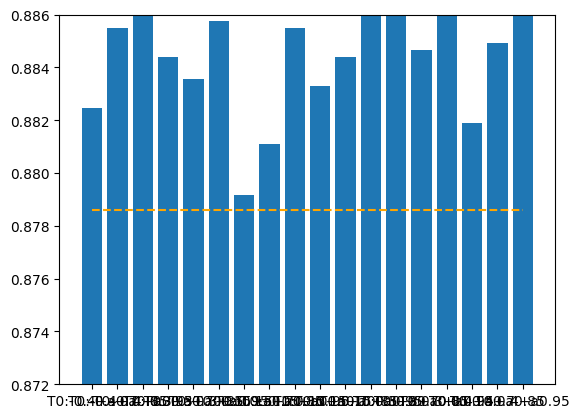


 ['T0:-0.4+a0.7' 'T0:-0.4+a0.85' 'T0:-0.4+a0.95' 'T0:-0.3+a0.7'
 'T0:-0.3+a0.85' 'T0:-0.3+a0.95' 'T0:-0.15+a0.7' 'T0:-0.15+a0.85'
 'T0:-0.15+a0.95' 'T0:0.15+a0.7' 'T0:0.15+a0.85' 'T0:0.15+a0.95'
 'T0:0.3+a0.7' 'T0:0.3+a0.85' 'T0:0.3+a0.95' 'T0:0.4+a0.7' 'T0:0.4+a0.85'
 'T0:0.4+a0.95'] 

No aug: 0.8786127167630058
Best aug: T0:0.15+a0.95 -> 0.8865951004679329

 (129, 2)


In [ ]:
#Trasl
Param = Trasl
S=Param.size
Pred = predT0
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'T0:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.886)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

In [ ]:
#pred #Trasl1
Param = Trasl
S=Param.size
predT1 = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predT1[qq][j] =  models[qq].predict(trasl(TestX[qq], 0, Param[j]))

38/38 [==============================] - 1s 29ms/step


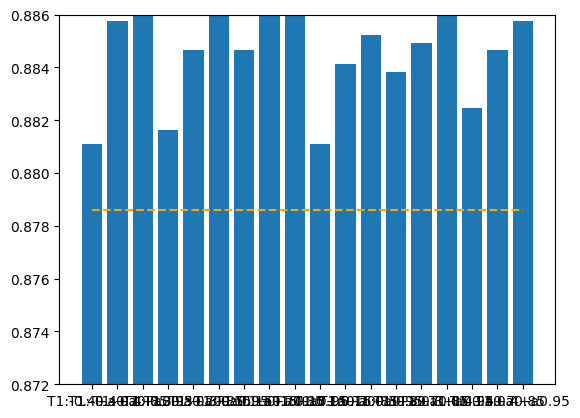


 ['T1:-0.4+a0.7' 'T1:-0.4+a0.85' 'T1:-0.4+a0.95' 'T1:-0.3+a0.7'
 'T1:-0.3+a0.85' 'T1:-0.3+a0.95' 'T1:-0.15+a0.7' 'T1:-0.15+a0.85'
 'T1:-0.15+a0.95' 'T1:0.15+a0.7' 'T1:0.15+a0.85' 'T1:0.15+a0.95'
 'T1:0.3+a0.7' 'T1:0.3+a0.85' 'T1:0.3+a0.95' 'T1:0.4+a0.7' 'T1:0.4+a0.85'
 'T1:0.4+a0.95'] 

No aug: 0.8786127167630058
Best aug: T1:-0.15+a0.85 -> 0.8876961189099918

 (147, 2)


In [ ]:
#Trasl1
Param = Trasl
S=Param.size
Pred = predT1
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'T1:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.886)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

# Rot + Zoom

In [ ]:
#pred #Rot
Param = Rot
S=Param.size
predR = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predR[qq][j] =  models[qq].predict(rotate(TestX[qq],Param[j]))

38/38 [==============================] - 1s 31ms/step


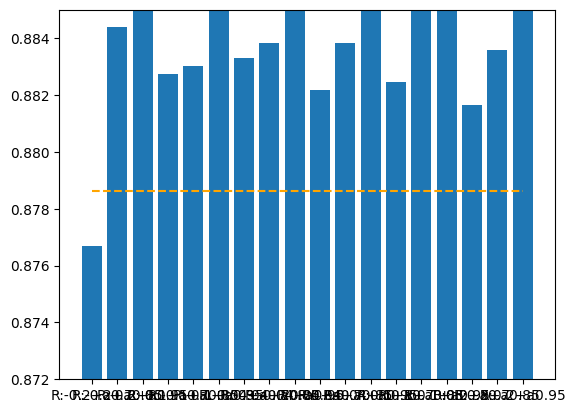


 ['R:-0.2+a0.7' 'R:-0.2+a0.85' 'R:-0.2+a0.95' 'R:-0.1+a0.7' 'R:-0.1+a0.85'
 'R:-0.1+a0.95' 'R:-0.04+a0.7' 'R:-0.04+a0.85' 'R:-0.04+a0.95'
 'R:0.04+a0.7' 'R:0.04+a0.85' 'R:0.04+a0.95' 'R:0.1+a0.7' 'R:0.1+a0.85'
 'R:0.1+a0.95' 'R:0.2+a0.7' 'R:0.2+a0.85' 'R:0.2+a0.95'] 

No aug: 0.8786127167630058
Best aug: R:-0.1+a0.95 -> 0.8879713735205064

 (164, 2)


In [ ]:
#Rot
Param = Rot
S=Param.size
Pred = predR
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'R:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.885)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

In [ ]:
#pred #Zoom
Param = Zoom
S=Param.size
predZ = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predZ[qq][j] =  models[qq].predict(zoom(TestX[qq],Param[j]))

38/38 [==============================] - 1s 30ms/step


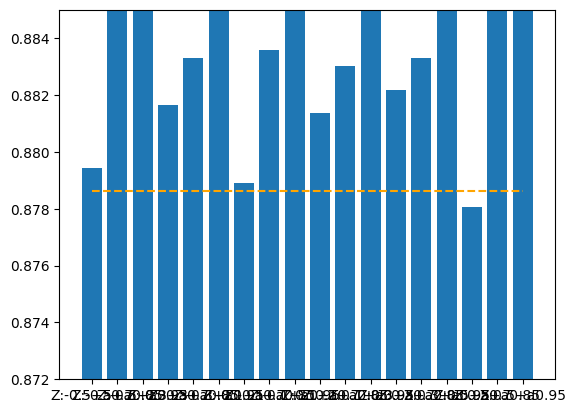


 ['Z:-0.5+a0.7' 'Z:-0.5+a0.85' 'Z:-0.5+a0.95' 'Z:-0.3+a0.7' 'Z:-0.3+a0.85'
 'Z:-0.3+a0.95' 'Z:-0.1+a0.7' 'Z:-0.1+a0.85' 'Z:-0.1+a0.95' 'Z:0.1+a0.7'
 'Z:0.1+a0.85' 'Z:0.1+a0.95' 'Z:0.3+a0.7' 'Z:0.3+a0.85' 'Z:0.3+a0.95'
 'Z:0.5+a0.7' 'Z:0.5+a0.85' 'Z:0.5+a0.95'] 

No aug: 0.8786127167630058
Best aug: Z:-0.1+a0.95 -> 0.8863198458574182

 (181, 2)


In [ ]:
#Zoom
Param = Zoom
S=Param.size
Pred = predZ
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'Z:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.885)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

# Bright + contr

In [ ]:
#pred #Bright
Param = Bright
S=Param.size
predB = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predB[qq][j] =  models[qq].predict(bright(TestX[qq],Param[j]))

38/38 [==============================] - 1s 30ms/step


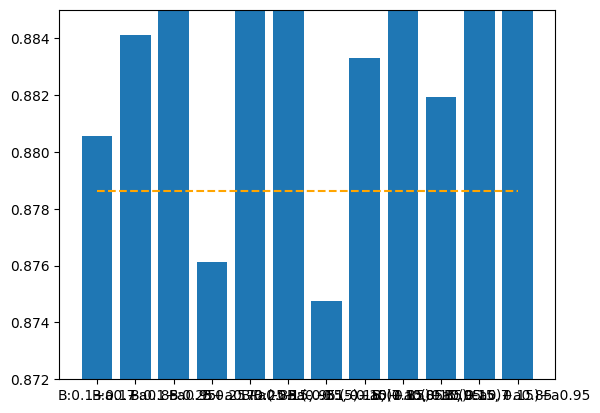


 ['B:0.1+a0.7' 'B:0.1+a0.85' 'B:0.1+a0.95' 'B:0.25+a0.7' 'B:0.25+a0.85'
 'B:0.25+a0.95' 'B:(-0.15, -0.15)+a0.7' 'B:(-0.15, -0.15)+a0.85'
 'B:(-0.15, -0.15)+a0.95' 'B:(0.15, 0.15)+a0.7' 'B:(0.15, 0.15)+a0.85'
 'B:(0.15, 0.15)+a0.95'] 

No aug: 0.8786127167630058
Best aug: B:0.1+a0.95 -> 0.8868703550784476

 (191, 2)


In [ ]:
#Bright
Param = Bright
S=Param.size
Pred = predB
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'B:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.885)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)

In [ ]:
#pred #Contrast
Param = Contr
S=Param.size
predC = np.empty((SPLITS,)+ (S,) + TestY[0].shape)

for qq in range(SPLITS):
  for j in  range(S):
    predC[qq][j] =  models[qq].predict(contrast(TestX[qq],Param[j]))

38/38 [==============================] - 1s 30ms/step


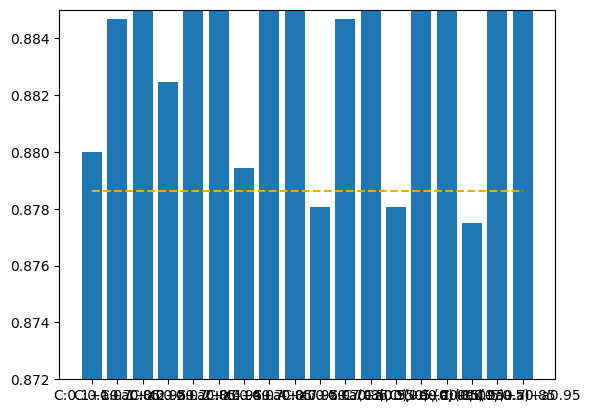


 ['C:0.1+a0.7' 'C:0.1+a0.85' 'C:0.1+a0.95' 'C:0.2+a0.7' 'C:0.2+a0.85'
 'C:0.2+a0.95' 'C:0.4+a0.7' 'C:0.4+a0.85' 'C:0.4+a0.95' 'C:0.7+a0.7'
 'C:0.7+a0.85' 'C:0.7+a0.95' 'C:(0.5, 0)+a0.7' 'C:(0.5, 0)+a0.85'
 'C:(0.5, 0)+a0.95' 'C:(0, 0.5)+a0.7' 'C:(0, 0.5)+a0.85'
 'C:(0, 0.5)+a0.95'] 

No aug: 0.8786127167630058
Best aug: C:0.7+a0.95 -> 0.8865951004679329

 (206, 2)


In [ ]:
#Contrast
Param = Contr
S=Param.size
Pred = predC
Iter = range(SPLITS)

# per vedere quella di UN SOLO SPLIT
#Iter=[2]

# cambiare solo sopra  (e il label)

Acc= np.empty(0)
Label=np.empty(0)


for jj in range(S):
  for a in Alpha:
    accuracy=[]
    for qq in Iter:
      P = a*predr[qq] + (1-a)*Pred[qq][jj]
      accuracy.append(accuracy_score(TestY[qq][:,1], np.argmax(P, axis=-1)))
    Label = np.append(Label, f'C:{Param[jj]}+a{a}')
    Acc = np.append(Acc,np.mean(accuracy))


fig = plt.figure()
plt.bar(Label, Acc)
plt.plot([Label[0], Label[-1]], [accf,accf] ,'--', color='orange')
plt.ylim(0.872, 0.885)
plt.show()
print('\n',Label, '\n')
print('No aug:', accf)
print('Best aug:', Label[np.argmax(Acc)], '->', Acc[np.argmax(Acc)])


for jj in range(Acc.size) :
  if(Acc[jj]>accf):
    Save = np.vstack([Save, [Label[jj], Acc[jj]]])
print('\n', Save.shape)